**Reproduction of:**

**Deep Convolutional Neural Networks and Data Augmentation for Environmental  Sound Classification** 

Justin Salamon and Juan Pablo Bello

Some code taken from https://github.com/jaron/deep-listening/blob/master/4-us8k-cnn-salamon.ipynb

# Preprocessing

In [1]:
#import os

#for dir in [load_dir, augmented_load_dir]:
#    for k in range(1,10+1):
#        filename = "fold"+str(k)+"_x.npy"
#        file_path = os.path.join(dir,filename)
#        file= np.load(file_path, allow_pickle = True)
#        file = file.astype('float32') 
#        np.save(file_path, file, allow_pickle = True)

In [2]:
#!git clone https://github.com/grudloff/Salomon2017Replication

In [3]:
import numpy as np
import math
import gc
#gc.set_debug(gc.DEBUG_STATS)

from preprocessing_augmented import load_folds
from model import build_model
from evaluation import evaluate

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import clear_session

from sklearn.metrics import confusion_matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from pywt import dwt2

load_dir = "CNN-Sound/data/us8k"
augmented_load_dir = "CNN-Sound/data/us8k-augmented"

C:\Users\monic\miniconda3\envs\deepsound\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\monic\miniconda3\envs\deepsound\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [4]:
wavelet = 'bior1.5'
frames = 68
bands=68
channels = 4

def wavedec(batch_x):
    new_batch_x = np.empty(shape = (batch_x.shape[0], frames, bands, channels),dtype = 'float32')
    for i, img in enumerate(batch_x):
        img = np.squeeze(img)
        img = (img - np.mean(img))/np.std(img)
    
        # 2D Discrete Wavelet Transform
        LL, (LH, HL, HH) = dwt2(img, wavelet)
        new_batch_x[i] = np.stack([LL,LH,HL,HH],axis=-1)# shape: [frames, bands, 4]
    
    return new_batch_x

class waveletGenerator(Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle):
        self.x, self.y = x_set, np.array(y_set)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(self.x.shape[0])

    def __len__(self):
        return math.ceil(self.x.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_x = wavedec(self.x[indexes])
        batch_y = self.y[indexes]

        return batch_x , batch_y

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

10-Fold Crossvalidation.

In [5]:
def train_fold(f):
    # load data
    train_x, test_x, val_x, train_y, test_y, val_y = load_folds(load_dir,augmented_load_dir, f)
    #train_gen, test_x, val_x, test_y, val_y = load_folds_pescador(load_dir,augmented_load_dir, f)

    train_gen = waveletGenerator(train_x, train_y, shuffle=True, batch_size=100)
    test_gen = waveletGenerator(test_x, test_y, shuffle=False, batch_size=100)
    val_gen = waveletGenerator(val_x, val_y, shuffle=False, batch_size=100)
    
    print("Building model...")
    model = build_model(f_size=3, frames=frames, bands=bands, channels=channels)

    # now fit the model to the training data, evaluating loss against the validation data
    print("Training model...")
    model.fit(train_gen, validation_data=test_gen, 
              callbacks=[EarlyStopping(restore_best_weights=True, patience=15)],
              epochs=100, workers=0)
    
    # now evaluate the trained model against the unseen test data
    print("Evaluating model...")
    return evaluate(model, val_gen, val_y)

In [6]:
acc = np.zeros(10)
roc = np.zeros(10)

CM = 0

for f in range(1,10+1):

    roc[f-1], acc[f-1], cm = train_fold(f)
    clear_session() # clear tensorflow variables
    gc.collect() #collect garbage
    CM += cm

    
print ('\nAverage R.O.C:', np.mean(roc))
print ('Average Accuracy:', np.mean(acc))

# using all folds: best ROC = 0.91, f-score = 0.592 (50 epochs)
# using 2 folds: average ROC = 0.792, average f-score = 0.335

# if you want to save the model, uncomment this...
#filepath = "models/salamon-cnn-model.h5"
#model.save(filepath)


*** Train on {2, 3, 4, 5, 6, 7, 9} Validate on 1 Test on 8 ***
val shape:  (873, 128, 128, 1)
test shape:  (806, 128, 128, 1)
train shape:  (148113, 128, 128, 1)
Building model...
Training model...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1482 steps, validate for 9 steps
Epoch 1/100
1482/1482 [==============================] - 75s 51ms/step - loss: 2.1361 - accuracy: 0.2670 - val_loss: 1.7958 - val_accuracy: 0.5385 loss: 2.3394 - accuracy: - ETA: 51s - loss: 2.3377 - accuracy:  - ETA: 50s - loss: 2.3357 - accuracy: 0 - ETA: 50s - loss: 2.333 - ETA: 48s - loss: 2. - ETA: 45s - ETA: 37s  - ETA: 34s   - ETA: 27s - loss: 2.2
Epoch 2/100
1482/1482 [==============================] - 67s 46ms/step - loss: 1.7480 - accuracy: 0.4226 - val_loss: 1.6063 - val_accuracy: 0.5087
Epoch 3/100
1482/1482 [==============================] - 67s 45ms/step - loss: 1.5337 - accuracy: 0.5049 - val_loss: 1.4538 - val_accuracy: 0.5906
Epoch 4/100
1482/1482 [==============================] - 

1472/1472 [==============================] - 66s 45ms/step - loss: 1.0759 - accuracy: 0.6670 - val_loss: 1.4470 - val_accuracy: 0.5621
Epoch 9/100
1472/1472 [==============================] - 67s 45ms/step - loss: 1.0357 - accuracy: 0.6822 - val_loss: 1.2504 - val_accuracy: 0.6110ccuracy: 0. - ETA: 35s -  - ETA: 33s - loss - ETA: 13s - loss: 1.0348 - accuracy: 0.683 -  - ETA: 2s - los
Epoch 10/100
1472/1472 [==============================] - 67s 46ms/step - loss: 0.9907 - accuracy: 0.6964 - val_loss: 1.2779 - val_accuracy: 0.6074
Epoch 11/100
1472/1472 [==============================] - 67s 45ms/step - loss: 0.9547 - accuracy: 0.7099 - val_loss: 1.1768 - val_accuracy: 0.6432 - los
Epoch 12/100
1472/1472 [==============================] - 67s 45ms/step - loss: 0.9209 - accuracy: 0.7195 - val_loss: 1.3362 - val_accuracy: 0.6098
Epoch 13/100
1472/1472 [==============================] - 67s 45ms/step - loss: 0.8875 - accuracy: 0.7309 - val_loss: 1.2699 - val_accuracy: 0.6337
Epoch 14/100
1

1472/1472 [==============================] - 66s 45ms/step - loss: 0.5865 - accuracy: 0.8202 - val_loss: 1.2528 - val_accuracy: 0.6504- los
Epoch 38/100
1472/1472 [==============================] - 66s 45ms/step - loss: 0.5812 - accuracy: 0.8209 - val_loss: 1.4601 - val_accuracy: 0.6002loss: 0.5642 - - ETA: 53s - loss: 0.5835 - accuracy: 0.818 - ETA: 53s - lo - ETA: 47s - loss: 0.5955 - a - - ETA: 2s - loss: 0.5835 - accuracy: 0. - ETA: 2s - loss: 0.5837 - ac - ETA: 1s - loss: 0.5832 - accuracy: 0. - ETA: 1s - loss: 0.5827 - accuracy: 0.82 - ETA: 1s - loss: 0.5827 - accuracy - ETA: 1s -
Epoch 39/100
1472/1472 [==============================] - 66s 45ms/step - loss: 0.5735 - accuracy: 0.8239 - val_loss: 1.2243 - val_accuracy: 0.6146
Epoch 40/100
1472/1472 [==============================] - 67s 45ms/step - loss: 0.5708 - accuracy: 0.8260 - val_loss: 1.3063 - val_accuracy: 0.62650.5805 - accur - ETA: 39s - loss: 0.5760 - accuracy: 0 - ETA: 38s - loss: 0.5751 - accuracy - ETA: 37s - loss: 

1443/1443 [==============================] - 65s 45ms/step - loss: 1.2229 - accuracy: 0.6169 - val_loss: 1.0935 - val_accuracy: 0.68069s - loss: 1.253 - ETA: 43s - loss: 1.2622 - ac - ETA: 42s - loss: 1 - ETA: 40s - loss: 1.2597 - accuracy: 0.602 - ETA: 40s - loss: 1.2607 - accurac - ETA: 39s - lo - ETA: 37s - loss: 1.2553 - ac - ETA: 32s - loss:  - ETA: 30s - loss: 1.2392 - accuracy - ETA: 29s - loss: 1.2384 -  - ETA: 28s - loss: 1.2379 - a - ETA: 27s - loss: 1.2325 - ac - ETA: 26s - loss: 1.23 - ETA: 24s - loss: 1.2327 - accuracy: 0.611 - ETA: - ETA: 21s - loss: 1.2303 - accu - ETA: 20 - ETA: 13s -  - ETA:  - ETA: 0s - loss: 1.2236 - accuracy: 
Epoch 7/100
1443/1443 [==============================] - 65s 45ms/step - loss: 1.1542 - accuracy: 0.6411 - val_loss: 1.0084 - val_accuracy: 0.7030 - ETA: 39s - loss: 1.1652 - accuracy: 0.6 - ETA: 39s - loss: 1.1663 - accuracy: 0. - ETA: 39s - loss: 1.1 - ETA: 37s - loss: 1.1603 - accuracy: 0.638 - ETA: 37s - loss: 1.1596 -  - ETA: 35 - ETA - E

1443/1443 [==============================] - 65s 45ms/step - loss: 0.7406 - accuracy: 0.7753 - val_loss: 0.8819 - val_accuracy: 0.7361098 - - ETA: 41s - loss: 0.7145  - ETA: 39s - loss: 0.7241 - accurac - ETA: 38s - loss: 0.7250 - accuracy: - ETA: 38s - loss: 0.7256 - accuracy: 0.7 - ETA: 38s - loss: 0.7245 - acc - ETA: 37s - loss: 0.732 - ETA: 35s - loss: 0.7267 - accu - ETA: 34s - loss: 0.7275 - accur - ETA: 33s - loss: 0.72 - ETA: 28s - loss: 0.7313 - accuracy:  - ETA: 27s - loss: 0.7312 - accu - ETA: 26s - - ETA: 20s - loss: 0.7360 - accura - ETA: 19s - loss: 0.7358 - - ETA: 1s
Epoch 22/100
1443/1443 [==============================] - 65s 45ms/step - loss: 0.7313 - accuracy: 0.7772 - val_loss: 0.8569 - val_accuracy: 0.7447445 - accuracy: 0.77 - E - ETA: 53s - loss: 0.7552 - accuracy: 0 - ETA: 53s - loss: 0.7 - ETA: 47s - loss: 0.7582 - acc - ETA: 46s - loss: 0.7549 -  - ETA: 45s - loss: 0.7448 - accura - ETA: 44s - loss: 0.7416 - accur - ETA: 43s - loss: 0.7484 - accur - ETA: 42s -

1443/1443 [==============================] - 65s 45ms/step - loss: 0.6093 - accuracy: 0.8127 - val_loss: 0.8738 - val_accuracy: 0.7799 50s - loss: - ETA: 48s - loss - ETA: 46s - loss: 0.5968 - accuracy: 0.8 - ETA: 45s - loss: 0.5966 - a - ETA: 44s - loss: 0.5970 - a - ETA: 43s - loss: 0.599 - ETA: 41s - loss - ETA: 24s - loss: 0.6057 - accuracy - ET - ETA: 21s - loss: 0.6067 - accu - ETA: 20s - loss: 0.6092 - accuracy: 0.8 - E - ETA: 16s - loss: 0.6104 - ac - ETA: 15s - loss: 0.6102 - accura - ETA: 14s - loss: 0.6098 - accuracy: 0 - ETA: 14s - loss: 0.6100 - accurac - ETA: 13s - loss: 0.6102 - - ETA: 3s - loss: 0.612 - ETA: 2s - loss: 0.6117 - accu - ETA: 2s - loss: 0 - ETA: 1s - los - ETA: 0s - loss: 0.6098 - accuracy: 0.81 - ETA: 0s - loss: 0.6096 - accuracy: 
Epoch 35/100
1443/1443 [==============================] - 65s 45ms/step - loss: 0.6079 - accuracy: 0.8138 - val_loss: 0.8727 - val_accuracy: 0.77560.6141 -  - ETA: 43 - ETA: 33s - loss: 0.6187 - accur - ETA: 32s - loss: 0.6156 

1443/1443 [==============================] - 65s 45ms/step - loss: 0.5525 - accuracy: 0.8295 - val_loss: 0.9100 - val_accuracy: 0.7639 - loss: 0.570 - ETA: 1: - ETA: 1:00 - loss: 0.53 - ETA: 59 - ETA: 52s - loss: 0.5333 - accuracy: 0 - ETA: 52s - loss: 0.5358 -  - ETA: 51s - loss: 0.5358 - a - ETA: 49s - loss: 0.5 - ETA: 48s  - ETA: 45s - loss: 0.5356 - accuracy: 0.835 - ETA: 45s - loss: 0.5363 - accuracy:  - ETA: 44s - loss: 0.5373 - accuracy: 0 - ETA: 44s - loss: 0.5411 - accuracy: 0. - ETA: 44s - loss: 0.5423 - accuracy:  - ETA: 43s - loss: 0.5418  - ETA: 42s - loss: 0.5429 - ac - ETA: 40s - loss: 0.5446 - accurac - ETA: 40s - loss: 0.5440 - accuracy: 0. - ETA: 39s - los - ETA: 37s - loss: 0.5423 - accuracy: 0.833 - ETA: 37s - loss: 0.544 - ETA: 35s - loss: 0.5416 - accu - ETA: 34s - loss: 0.5388 - accuracy: 0. - ETA: 34s - loss: 0.5395 - accur - ETA: 33s - loss: 0.5413 - accuracy: 0. - ETA: 33s - l - ETA: 30s - loss: 0.5456 - ETA: 29s - loss: 0.5502 - accur - ETA: 28s - loss: 0.550

1432/1432 [==============================] - 65s 45ms/step - loss: 1.4405 - accuracy: 0.5454 - val_loss: 1.7206 - val_accuracy: 0.460538s - loss: 1.4772 - accuracy: 0.531 - ETA: 38s - loss: 1.4785 - accuracy: 0. - ETA: 38s - loss: 1.4782 -  - ETA: - ETA: 33s - loss: 1.4750 - accur - ETA: 33s - loss: 1. - ETA: 31s - loss: 1.4697 - accura - ETA: 30s - loss: 1.4696 - ac - ETA: 29s - loss - ETA: 26s - lo - ETA: 24s - loss: 1.4616 - a - ETA: 23s - loss: 1.4577 - accuracy: - ETA: 22s - loss: 1.4583 - accuracy: 0.538 - ETA: 22s - ETA: 16s - loss: 1.4507 - ac - ETA: 15s - loss: 1.4520 - acc - ET - ETA: 5s - loss: 1.4460 - ac - ETA: 4s - loss: 1.4
Epoch 5/100
1432/1432 [==============================] - 65s 45ms/step - loss: 1.3241 - accuracy: 0.5861 - val_loss: 1.5760 - val_accuracy: 0.5092 ac - ETA: 4 - ETA: 46s - loss: 1.35 - ETA: 44s - loss: 1.3590 - accuracy: 0.570 - ETA: 44s - loss: 1.3604 - accur - ETA: 35s - loss: 1.3517 -  - ETA: 34s - loss: 1.3531 - accuracy: - ETA: 34s - loss: - ETA:

1432/1432 [==============================] - 65s 46ms/step - loss: 0.7587 - accuracy: 0.7694 - val_loss: 2.0400 - val_accuracy: 0.5276TA: 1:00 - loss: 0 - ETA: 1:00  - ETA: 57s - loss: 0.7715 -  - ETA: 55s - lo - ETA: 53s - loss:  - ETA: 47s - loss: 0.7785 - accuracy: - ETA: 46s - loss: 0.7821 - ac - ETA: 45s - loss: 0.7768 - acc  - ETA: 4 - ETA: 34s - - ETA: 28s - loss: 0.7697 - accuracy: 0.766 - ETA: 28s - loss: 0.7697   - ETA: 22s - loss: 0.7709 - accuracy:  - ETA: 22s - los - ETA: 20s - loss: 0.7729 - accuracy: 0.764 - ETA: - ETA: 16s - loss: 0.7696 - a - ETA: 15s - loss: 0.7681 - accuracy - ETA: 1s - loss: 0.760 - ETA: 0s - loss: 0.7588 - 
Epoch 20/100
1432/1432 [==============================] - 65s 45ms/step - loss: 0.7418 - accuracy: 0.7747 - val_loss: 1.4440 - val_accuracy: 0.580554 - accuracy: 0. - ETA: 44s - loss: 0.7392 - accuracy: 0 - ETA: 44s - loss: 0.7377 - accuracy: 0. - ETA: 43s - loss: 0.7363 - accuracy:  - ETA: 43s - loss - ETA: 41s - loss - ETA: 39s  - ETA: 21s - l

1432/1432 [==============================] - 65s 45ms/step - loss: 0.6025 - accuracy: 0.8161 - val_loss: 1.9243 - val_accuracy: 0.5773ETA: 52s - loss: 0.5945 - accuracy: - ETA: 51s - loss: 0.5928 - accuracy: 0. - ETA: 51s - loss: 0.5920 - - ETA: 50s - loss: 0.5910 - accuracy:  - ETA: 49s - loss: 0.5926 - accurac - ETA: 48s - loss: 0.5883 - ac - ETA: 47 - ETA: 44s - - ETA: 38s - loss: 0.5914 - accuracy: 0 - ETA: 38s - lo - ETA: 35s - loss: 0.5892 - a - ETA: 34s - loss: 0.5870 - accuracy:  - ETA: 34s - loss: 0.5881 - accu - ETA: 33s - loss: 0.5886 - accur - ETA: 32s - loss: 0.5882 - a - ETA: 31s - loss: 0.5916 - accuracy: 0.8 - ETA: 30s - loss: 0.5923 - accurac - ETA: 30s - loss: 0.5936 - accur - ETA: 29s - loss: 0.5971 - - ETA: 27s - loss: 0.5990 - accuracy - ETA: 23s - los - ETA: 21s - loss: 0.6021 - accuracy: 0.816 - ETA: 21s - loss: 0.6018 - accurac - ETA: 20s - loss: 0.601 - ETA: 18s - loss: 0.6011 - accuracy:  - ETA: 18s - loss: 0.6026 - accuracy: 0. - ETA: 17s - loss:  - ETA: 7s -

1465/1465 [==============================] - 66s 45ms/step - loss: 0.9201 - accuracy: 0.7188 - val_loss: 1.5346 - val_accuracy: 0.55777 - ETA: 56s - loss: 0.888 - ETA: 54s - loss: 0.8 - ETA: 41s - loss: 0.8973 - accuracy:  - ETA: 40s - loss: 0.8977 - ac - ETA: 39s
Epoch 13/100
1465/1465 [==============================] - 66s 45ms/step - loss: 0.8900 - accuracy: 0.7287 - val_loss: 1.7078 - val_accuracy: 0.5553racy: - ETA: 53s - loss: 0.8901 - ac - ETA: 52s - loss: 0.8932 - accuracy:  - ETA: 52s - loss: 0.8881 - accur - - ETA: 48s - loss: 0.8801 - ac - ETA: 47s - loss: 0.8843 - accuracy: - ETA: 46s - loss: 0.88 - ETA: 15s - loss: 0.8964 - accura - ETA:
Epoch 14/100
1465/1465 [==============================] - 66s 45ms/step - loss: 0.8711 - accuracy: 0.7339 - val_loss: 1.4883 - val_accuracy: 0.5601ss: 0.8671 -  - ETA: 43s - lo - ETA: 41s - loss: 0.8715 - accuracy: 0.734 - ETA: 41s - loss: 0.8 - ETA: 39s - loss: 0.8733 - ac - ETA: 38s - loss: 0.86 - ETA: 36s - loss: 0.8707  - ETA: 35s - lo

1485/1485 [==============================] - 67s 45ms/step - loss: 1.4285 - accuracy: 0.5432 - val_loss: 1.4078 - val_accuracy: 0.5274
Epoch 5/100
1485/1485 [==============================] - 67s 45ms/step - loss: 1.3236 - accuracy: 0.5804 - val_loss: 1.4887 - val_accuracy: 0.5334 1.3800 - accuracy: 0.567 - ETA: 52s - loss: 1.3776 - accurac - ETA: 51s - loss - ETA: 49s - loss: 1.3631 - accurac - ETA: 48s - loss: 1.3682 - a - ETA: 47s - - ETA: 44s - loss: 1.3575 - - ETA: 43s - loss: 1.3568 - accuracy: 0.569 - ETA: 42s - loss: 1.3567 - ETA: 41s - loss: 1 - ETA: 39s - loss: 1. - ETA: 33s - loss: - ETA: 31s - loss:
Epoch 6/100
1485/1485 [==============================] - 67s 45ms/step - loss: 1.2445 - accuracy: 0.6066 - val_loss: 1.4463 - val_accuracy: 0.5274 - accurac - ETA: 53s - loss: 1.3013 - accuracy:  - ETA: 52s - loss: 1.2970 - a - ETA: 51s - loss: 1.2985 - accuracy: 0. - ETA: 51s - loss: 1.2974 - accuracy: 0.588 - ETA: 5 - ETA: 48s - loss: 1.2923 - accuracy: - ETA:
Epoch 7/100
1485

1485/1485 [==============================] - 67s 45ms/step - loss: 1.5193 - accuracy: 0.5072 - val_loss: 1.6712 - val_accuracy: 0.4168 loss: 1.5931 - accuracy: 0.479 - ETA: 43 - ETA: 40s - 
Epoch 4/100
1485/1485 [==============================] - 67s 45ms/step - loss: 1.3841 - accuracy: 0.5575 - val_loss: 1.6706 - val_accuracy: 0.4447: 55s - lo - ETA: 52s - loss: 1.4124 - accuracy: 0.55 - ETA: 48s - loss: 1.4082 - accura - ETA - E - ETA: 30s - loss: 1.3981 - - ETA: 29s - loss: 1.4026  - ETA: 27s - - ETA: 21s - loss: 1.3 - ETA: 1 - ETA: 16s - loss:  - ETA: 11s - loss: 1.3885 - accurac - ETA: 10s - loss: 1.3879 - accuracy: 0.556 - ETA: 10s - loss: 1.3875 -  - ETA: 9s - loss: 1.3879 - 
Epoch 5/100
1485/1485 [==============================] - 67s 45ms/step - loss: 1.2866 - accuracy: 0.5915 - val_loss: 1.5333 - val_accuracy: 0.5091 1.3153 - accuracy: 0 - ETA: 53s - loss: 1.3225 - accuracy: 0. - ETA: 53s - loss: 1.3195  - ETA: 51s - loss: 1.3239 - accuracy - ETA:  - ETA:
Epoch 6/100
1485/148

1485/1485 [==============================] - 67s 45ms/step - loss: 0.6212 - accuracy: 0.8110 - val_loss: 1.2552 - val_accuracy: 0.6549- loss: - ETA: 19s - loss: 0.61 - ETA: 17s - loss: 0.6203 - accuracy:  - ETA: 17s - lo
Epoch 32/100
1485/1485 [==============================] - 67s 45ms/step - loss: 0.6147 - accuracy: 0.8122 - val_loss: 1.1880 - val_accuracy: 0.6525
Epoch 33/100
1485/1485 [==============================] - 67s 45ms/step - loss: 0.6052 - accuracy: 0.8144 - val_loss: 1.2605 - val_accuracy: 0.6549
Epoch 34/100
1485/1485 [==============================] - 67s 45ms/step - loss: 0.5974 - accuracy: 0.8180 - val_loss: 1.2907 - val_accuracy: 0.6671los - ETA: 55s - loss: 0.5899  - ETA: 53s - loss: 0.5958 - accu - ETA: 52s - loss: 0.5978 - accura - ETA: 51s - loss: 0.5948 - accuracy: 0.820 - ETA: 51s - loss: 0.5952 - accura - ETA: 32s - loss:  - ETA: 30 - ETA: 12s - loss: 0.5957 - ac
Epoch 35/100
1485/1485 [==============================] - 67s 45ms/step - loss: 0.5949 - accuracy

1494/1494 [==============================] - 67s 45ms/step - loss: 0.7910 - accuracy: 0.7621 - val_loss: 1.5124 - val_accuracy: 0.70227930 - accu - ETA: 20s - loss: 0.7924 -
Epoch 17/100
1494/1494 [==============================] - 67s 45ms/step - loss: 0.7698 - accuracy: 0.7674 - val_loss: 1.5106 - val_accuracy: 0.7132
Epoch 18/100
1494/1494 [==============================] - 68s 45ms/step - loss: 0.7446 - accuracy: 0.7750 - val_loss: 1.5920 - val_accuracy: 0.7047A: 58s  - ETA: 56s - loss: 0.7339 - ETA: 54s  - ETA: 51s - ETA: 34s - loss: 0.7408 - accuracy - ETA: 33s - loss: 0.739 - - ETA: 24s - loss: 0.7403 - accuracy: 0.776 - ETA: 24s  - ETA: 22s - loss: 0.7441 -  - ETA: 20s - l - ETA
Epoch 19/100
1494/1494 [==============================] - 67s 45ms/step - loss: 0.7233 - accuracy: 0.7813 - val_loss: 1.3837 - val_accuracy: 0.7194uracy:  - ETA: 0s - loss: 0.7242 - 
Epoch 20/100
1494/1494 [==============================] - 67s 45ms/step - loss: 0.7145 - accuracy: 0.7846 - val_loss: 1.5

1487/1487 [==============================] - 68s 45ms/step - loss: 0.9405 - accuracy: 0.7147 - val_loss: 1.2086 - val_accuracy: 0.615806 - loss: 0.9711 - accuracy: 0. - ETA: 1:06 - los - ETA: 1:02 - loss: 0.9437 - accuracy:  - ETA -  - ETA: 46s - loss: 0.9551 - accuracy: 0 - ETA: 45s - - ETA: 39s - loss: 0.9517 - accu - ETA: 38s - loss: 0.947 - ETA: 36s - loss: 0.9443 - accuracy:  - ETA:  - ETA: 33s - l - ETA - ETA: 27s - loss: 0.9480 - accuracy - ETA: 26s - loss: 0.9460 - accuracy:  - ETA: 26s - loss: 0.9477 - accuracy: 0 - ETA: 25s - loss: 0.9462 - accura - ETA: 21s - loss: 0.9423 - a - ETA: 16s - loss: 0.9392 - - ETA: 11s - loss: 0.9387 - acc - ETA: 2s - loss:
Epoch 12/100
1487/1487 [==============================] - 68s 45ms/step - loss: 0.9075 - accuracy: 0.7255 - val_loss: 1.1982 - val_accuracy: 0.637257s -  - ETA: - ETA: 51s - loss: 0.9189 - a - ETA: 50s - loss: 0.9155 -  - ETA: 49s  - ETA: 46s - loss: 0.9071 
Epoch 13/100
1487/1487 [==============================] - 67s 45ms/st

1487/1487 [==============================] - 67s 45ms/step - loss: 0.6435 - accuracy: 0.8054 - val_loss: 1.2442 - val_accuracy: 0.6193 los - ETA: 47s - loss: 0.6397 - accuracy: - ETA: 46s - loss: 0.6371 - accuracy: 0.80  - ETA: 39s - loss:  - ET - ETA: 26s - loss: 0.6462 - accura - ETA: 25s - l - ETA: 22s - loss: 0.6432 - accuracy: 0. - ETA: 22s - loss: 0.6425 - accuracy: 0 - ETA: 
Epoch 29/100
1487/1487 [==============================] - 67s 45ms/step - loss: 0.6319 - accuracy: 0.8089 - val_loss: 1.1798 - val_accuracy: 0.6504: 0.6167 - accuracy: - ETA: 50s - loss: 0.6150 - accuracy: - ETA: 50s - loss: 0.6166 - accu - ETA: 45s - loss: 0.6173 - accu - ETA: 44s - loss: 0.6178 - accuracy: 0. - ETA: 44s - loss: 0.6167 - ETA: 35s - loss: 0.6147 - accuracy:  - ETA: 34s - loss: 0.6156 - a - ETA: 33s - loss: 0.6162 - accuracy: 0.81 - ETA: 33s - loss: 0.6165 - accurac - ETA: 32s - loss: 0.6169  - ETA: 31s - loss: 0.618 - ETA: 22s - loss: 0.6222 - accuracy: 0.811 - ETA: 22s - loss: 0.6223  - ETA

1489/1489 [==============================] - 67s 45ms/step - loss: 1.5664 - accuracy: 0.4919 - val_loss: 1.3588 - val_accuracy: 0.5943A: 39s - loss: 1.6133 - accuracy: 0. - ETA: 39s - loss: 1.6133 - acc - ETA: 37s - loss: 1.61 - ETA: 36s - loss: 1.610 - ETA: 34s - loss: 1.6074 - accuracy: 0.477 - ETA: 34s - loss: 1.6073 - accurac - ETA: 33s - loss: 1.6068 - accu - ETA: 32s - loss: 1.6099 - ac - - ETA: 28s - loss: 1.6023 - accuracy: 0.479 - ETA: 27s - loss: 1.6035 - accuracy - ETA: 27 - ETA: 24s - loss: 1.5962 - accuracy:  - ETA: 23s - loss: 1.5945 - accuracy: 0.482 - ETA: 23s - l - ETA: 21s - loss: 1.5948 - - ETA: 19s - loss: 1.5893 - ETA: 18s - loss: - ETA: 12s - loss: 1.5817 -  - ET
Epoch 4/100
1489/1489 [==============================] - 67s 45ms/step - loss: 1.4058 - accuracy: 0.5476 - val_loss: 1.3859 - val_accuracy: 0.5298
Epoch 5/100
1489/1489 [==============================] - 67s 45ms/step - loss: 1.2880 - accuracy: 0.5901 - val_loss: 1.3088 - val_accuracy: 0.6166
Epoch 6/100


1489/1489 [==============================] - 67s 45ms/step - loss: 0.5758 - accuracy: 0.8233 - val_loss: 1.5218 - val_accuracy: 0.6154 - ETA: 2s - loss:
Epoch 40/100
1489/1489 [==============================] - 67s 45ms/step - loss: 0.5705 - accuracy: 0.8245 - val_loss: 1.2078 - val_accuracy: 0.6873ss: 0.5606 - accuracy: 0.8 - ETA: 59s - loss: 0.5574 - accur - ETA: 58s - loss: 0.5626 - ac - ETA: 57s  - ETA: 47s - loss: 0.5732 - accuracy - ETA: 46s - loss: 0.5749 - accuracy: 0.8 -  - ETA: 42s - loss: 0.5751 - accuracy: 0 - ETA: 42s - loss: 0.57
Evaluating model...
ROC: 0.968
  ...
    to  
  ['...']

Accuracy = 0.77
F-Score: 0.77

Average R.O.C: 0.9436346429971447
Average Accuracy: 0.6574656188488006


{'whiskers': [<matplotlib.lines.Line2D at 0x291dc61d3c8>,
 'caps': [<matplotlib.lines.Line2D at 0x291e9d35808>,
 'boxes': [<matplotlib.lines.Line2D at 0x291dc61da08>],
 'medians': [<matplotlib.lines.Line2D at 0x29227009f88>],
 'fliers': [<matplotlib.lines.Line2D at 0x291e97e16c8>],
 'means': []}

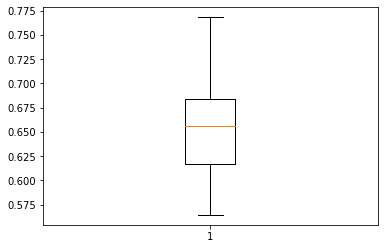

In [7]:
plt.boxplot(acc)

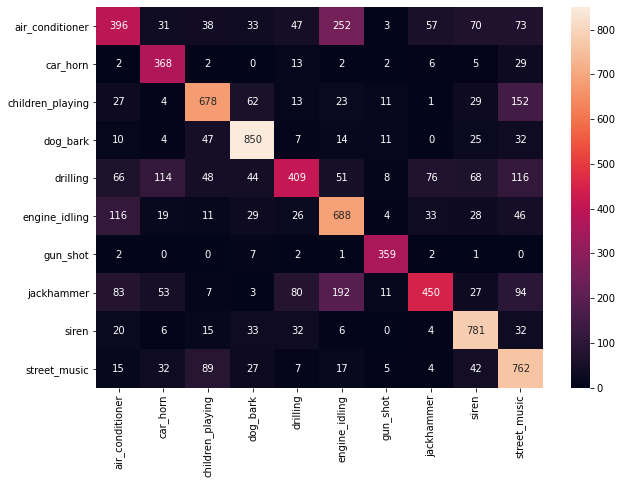

In [8]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

classes = ['air_conditioner',
           
'car_horn',
'children_playing',
'dog_bark',
'drilling',
'engine_idling',
'gun_shot',
'jackhammer',
'siren',
'street_music']
df_cm = pd.DataFrame(CM, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,  fmt='d')

In [9]:
np.save("acc_augmented_wav.npy", acc)
np.save("cm_agumented_wav.npy", CM)